### Imported Libraries

In [38]:
import datetime

import tensorflow as tf
import tensorflow_hub as hub

import PIL.Image as Image
import matplotlib.pylab as plt

import numpy as np
%load_ext tensorboard
from keras.applications.mobilenet import preprocess_input

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### ImageNet Classifier

In [39]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

In [40]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

Running on single image

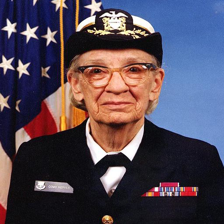

In [41]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [42]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape
grace_hopper

array([[[0.09803922, 0.10980392, 0.32156863],
        [0.11372549, 0.12156863, 0.35686275],
        [0.10588235, 0.10980392, 0.37254902],
        ...,
        [0.28627451, 0.43529412, 0.7254902 ],
        [0.27058824, 0.41960784, 0.71372549],
        [0.2745098 , 0.42352941, 0.71764706]],

       [[0.10980392, 0.12156863, 0.33333333],
        [0.10588235, 0.11372549, 0.35294118],
        [0.10588235, 0.10980392, 0.36862745],
        ...,
        [0.30196078, 0.44705882, 0.73333333],
        [0.31764706, 0.4627451 , 0.74901961],
        [0.31372549, 0.45882353, 0.74509804]],

       [[0.10588235, 0.11764706, 0.32941176],
        [0.10980392, 0.11764706, 0.35294118],
        [0.11764706, 0.12156863, 0.38039216],
        ...,
        [0.33333333, 0.4745098 , 0.75294118],
        [0.31372549, 0.45882353, 0.7372549 ],
        [0.3254902 , 0.47058824, 0.74901961]],

       ...,

       [[0.62745098, 0.03921569, 0.09019608],
        [0.63137255, 0.05490196, 0.09411765],
        [0.59215686, 0

Adding batch dimention

In [43]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result

1/1 [==============================] - 1s 588ms/step


array([[ 0.19971314,  1.0666499 , -0.10109264, ...,  0.1568822 ,
        -0.60558647, -0.04497403]], dtype=float32)

In [44]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=653>

Decode and Prediction

In [45]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
imagenet_labels[:10]

array(['background', 'tench', 'goldfish', 'great white shark',
       'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock',
       'hen'], dtype='<U30')

In [46]:
imagenet_labels[653]

'military uniform'

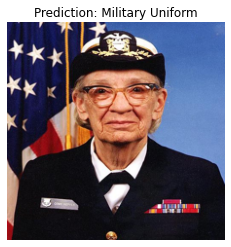

In [47]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Transfer Leaning
To do:
1. Select a pre-trained model from TensorFlow Hub; and
2. Retrain the top (last) layer to recognize the classes from your custom dataset.

### Dataset

In [48]:
data_root = "multi-plant-disease-dataset"

In [49]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

#### Split dataset

In [50]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

Found 20637 files belonging to 15 classes.
Using 14446 files for training.


In [51]:
train_label = np.concatenate([y for x, y in train_ds], axis=0)

In [85]:
len(train_label)

14446

In [53]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

Found 20637 files belonging to 15 classes.
Using 6191 files for validation.


In [54]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [55]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 156
Number of test batches: 38


In [56]:
len(train_ds)

452

In [57]:
len(val_ds)

156

In [58]:
len(test_ds)

38

### Classes

In [59]:
class_names = np.array(train_ds.class_names)
print(class_names)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [60]:
len(class_names)

15

### Rescaling
Because TensorFlow Hub's convention for image models is to expect float inputs in the [0, 1] range, use the tf.keras.layers.Rescaling preprocessing layer to achieve this.

In [61]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

### Caching
input pipeline by using buffered prefetching with Dataset.prefetch, so you can yield the data from disk without I/O blocking issues.

In [62]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Shapes check

In [63]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


### Run classifier on a branch of image

In [64]:
result_batch = classifier.predict(train_ds)

452/452 [==============================] - 352s 778ms/step


In [65]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['head cabbage', 'head cabbage', 'bonnet', ..., 'head cabbage',
       'head cabbage', 'backpack'], dtype='<U30')

#### Check the Predictions

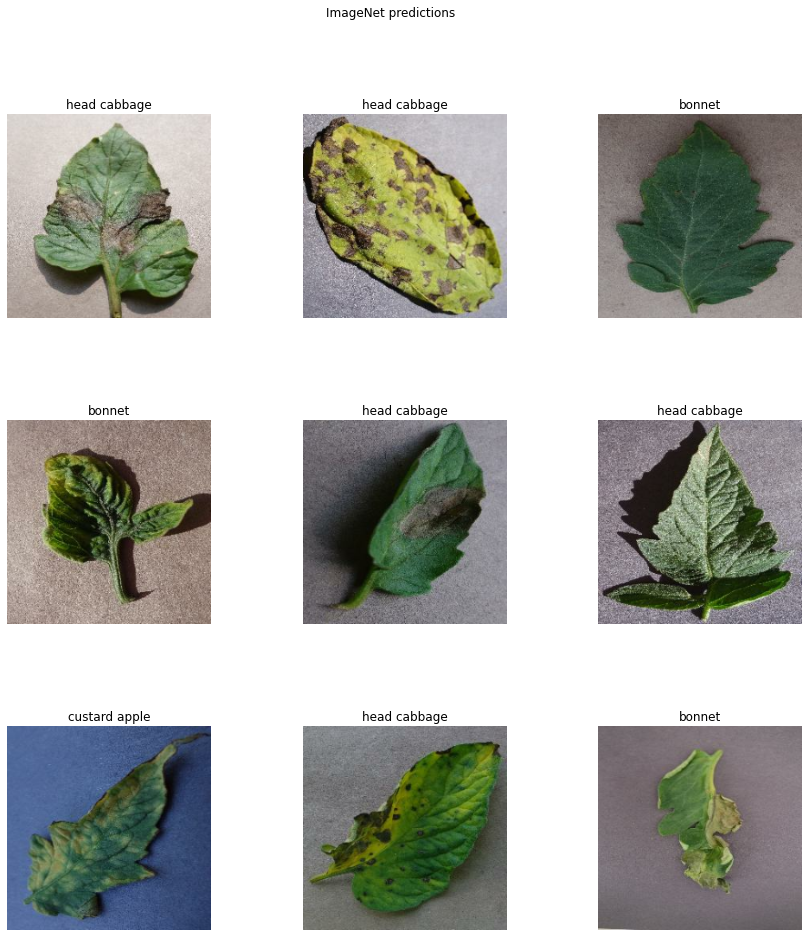

In [66]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.5)
for n in range(9):
  plt.subplot(3,3,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

The results are far from perfect, but reasonable considering that these are not the classes the model was trained for

## Main Training Process

### Download headless model

In [67]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

Create the feature extractor by wrapping the pre-trained model as a Keras layer with hub.KerasLayer. Use the trainable=False argument to freeze the variables, so that the training only modifies the new classifier layer:

In [68]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

The feature extractor returns a 1280-long vector for each image (the image batch size remains at 32 in this example):

In [69]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


### Attach a classification head

In [70]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 15)                19215     
                                                                 
Total params: 2,277,199
Trainable params: 19,215
Non-trainable params: 2,257,984
_________________________________________________________________


In [71]:
predictions = model(image_batch)

In [72]:
predictions.shape

TensorShape([32, 15])

### Train the model

In [73]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [74]:
NUM_EPOCHS = 2

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/2
452/452 [==============================] - 526s 1s/step - loss: 0.7102 - acc: 0.7959 - val_loss: 0.3984 - val_acc: 0.8778
Epoch 2/2
452/452 [==============================] - 517s 1s/step - loss: 0.3293 - acc: 0.9008 - val_loss: 0.3167 - val_acc: 0.8991


In [75]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 13216), started 3 days, 23:59:35 ago. (Use '!kill 13216' to kill it.)

### Check the predictions

In [76]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 5s 5s/step
['Tomato_Late_blight' 'Potato___Early_blight' 'Tomato_Bacterial_spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato_Late_blight'
 'Tomato_healthy' 'Tomato_Leaf_Mold' 'Tomato_Early_blight'
 'Tomato_Late_blight' 'Tomato_Bacterial_spot' 'Tomato_Bacterial_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato_Leaf_Mold'
 'Tomato_Bacterial_spot' 'Tomato_Bacterial_spot' 'Tomato_healthy'
 'Tomato_Bacterial_spot' 'Pepper__bell___healthy'
 'Tomato__Tomato_YellowLeaf__Curl_Virus'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato_Septoria_leaf_spot'
 'Tomato_Septoria_leaf_spot' 'Tomato_Early_blight'
 'Tomato_Septoria_leaf_spot' 'Tomato__Tomato_YellowLeaf__Curl_Virus'
 'Tomato_Late_blight' 'Tomato__Tomato_YellowLeaf__Curl_Virus'
 'Potato___Early_blight' 'Tomato_healthy' 'Tomato_Late_blight'
 'Tomato_Early_blight' 'Pepper__bell___Bacterial_spot']


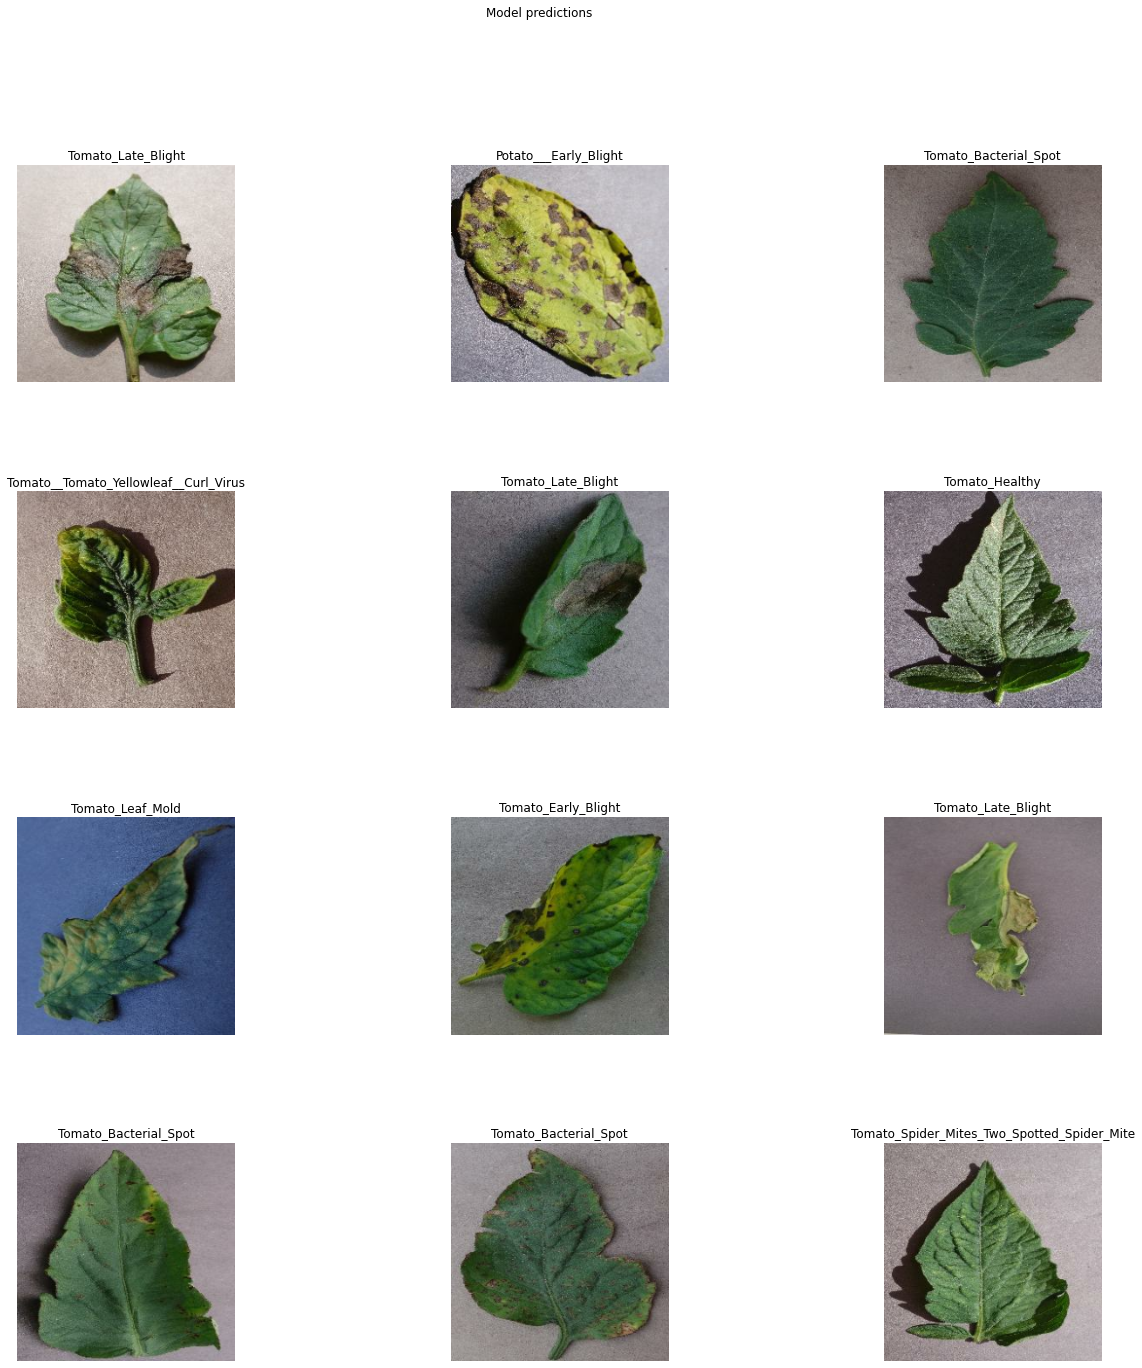

In [77]:
plt.figure(figsize=(22,22))
plt.subplots_adjust(hspace=0.5)

for n in range(12):
  plt.subplot(4,3,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

### Test

In [78]:
for test_batch, test_labels_batch in test_ds:
  print(test_batch.shape)
  print(test_labels_batch.shape)

(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)


In [98]:
test_batch

<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[0.5492997 , 0.5022409 , 0.55714285],
         [0.54923975, 0.5021809 , 0.5570829 ],
         [0.54761904, 0.5005603 , 0.5554622 ],
         ...,
         [0.562285  , 0.5230693 , 0.5662066 ],
         [0.57136863, 0.53215295, 0.5752902 ],
         [0.58377373, 0.54455805, 0.5876953 ]],

        [[0.55456185, 0.50750303, 0.562405  ],
         [0.5529412 , 0.5058824 , 0.56078434],
         [0.54845935, 0.5014006 , 0.5563025 ],
         ...,
         [0.5689076 , 0.52969193, 0.57282925],
         [0.5788917 , 0.539676  , 0.58281326],
         [0.5892959 , 0.55008024, 0.5932175 ]],

        [[0.56050426, 0.51344544, 0.5683474 ],
         [0.55602247, 0.50896364, 0.5638656 ],
         [0.5515406 , 0.5044818 , 0.55938375],
         ...,
         [0.57366955, 0.5344538 , 0.5775911 ],
         [0.582333  , 0.54311734, 0.5862546 ],
         [0.5939378 , 0.55472213, 0.5978594 ]],

        ...,

        [[0.35136017, 0.34463757,

In [86]:
predicted_batch = model.predict(test_ds)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

38/38 [==============================] - 31s 740ms/step
['Tomato__Tomato_YellowLeaf__Curl_Virus'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato_Septoria_leaf_spot'
 ... 'Potato___healthy' 'Potato___Late_blight' 'Potato___Late_blight']


In [99]:
predicted_label_batch

array(['Tomato__Tomato_YellowLeaf__Curl_Virus',
       'Tomato_Spider_mites_Two_spotted_spider_mite',
       'Tomato_Septoria_leaf_spot', ..., 'Potato___healthy',
       'Potato___Late_blight', 'Potato___Late_blight'], dtype='<U43')

In [88]:
test_label = np.concatenate([y for x, y in test_ds], axis=0)

In [89]:
cm = tf.math.confusion_matrix(labels=test_label, predictions=predicted_id)
cm

<tf.Tensor: shape=(15, 15), dtype=int32, numpy=
array([[ 74,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,  76,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0],
       [  0,   0,  58,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,
          0,   0],
       [  0,   0,   2,  50,   0,   0,   1,   1,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   1,   0,   0,   7,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 118,   2,   0,   0,   4,   0,   0,   1,
          0,   0],
       [  0,   0,   0,   1,   0,   2,  41,   3,   0,   4,   1,   3,   1,
          0,   1],
       [  0,   0,   0,   1,   0,   0,   7, 121,   1,   1,   0,   3,   2,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   3,   1,  42,   1,   0,   6,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   4,   1,   0,   0,  90,   1,   6,   3,
          0,   3],
       [  0,   0,   0,   0,   0,

Text(114.0, 0.5, 'Truth')

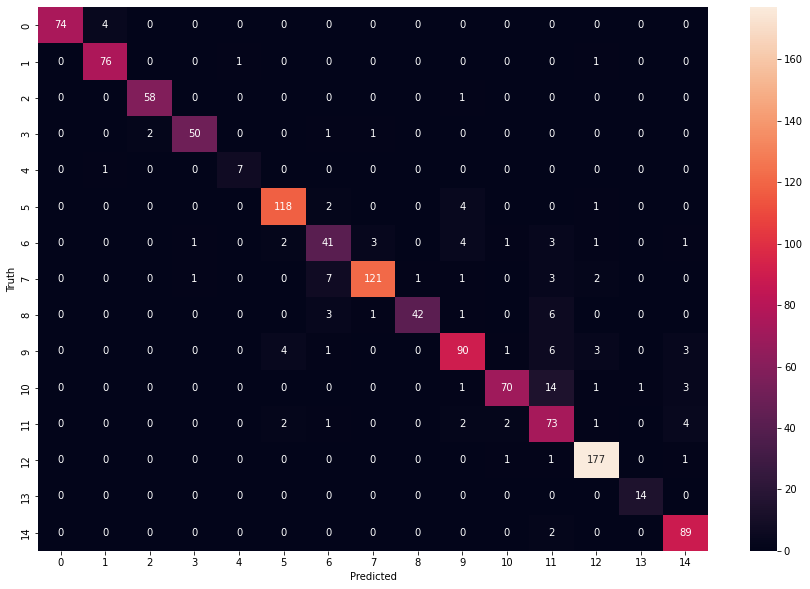

In [90]:
import seaborn as sn
plt.figure(figsize = (15,10))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [93]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [95]:
EPOCHS=2

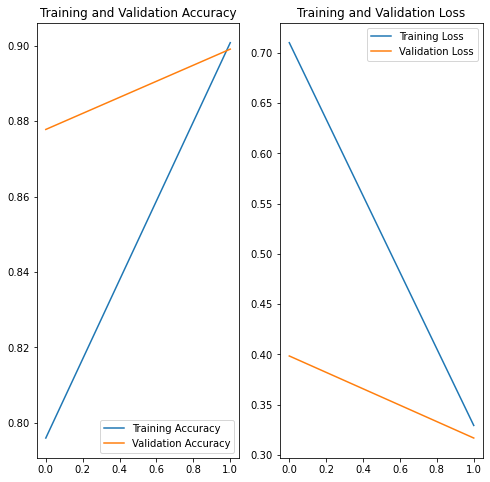

In [96]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

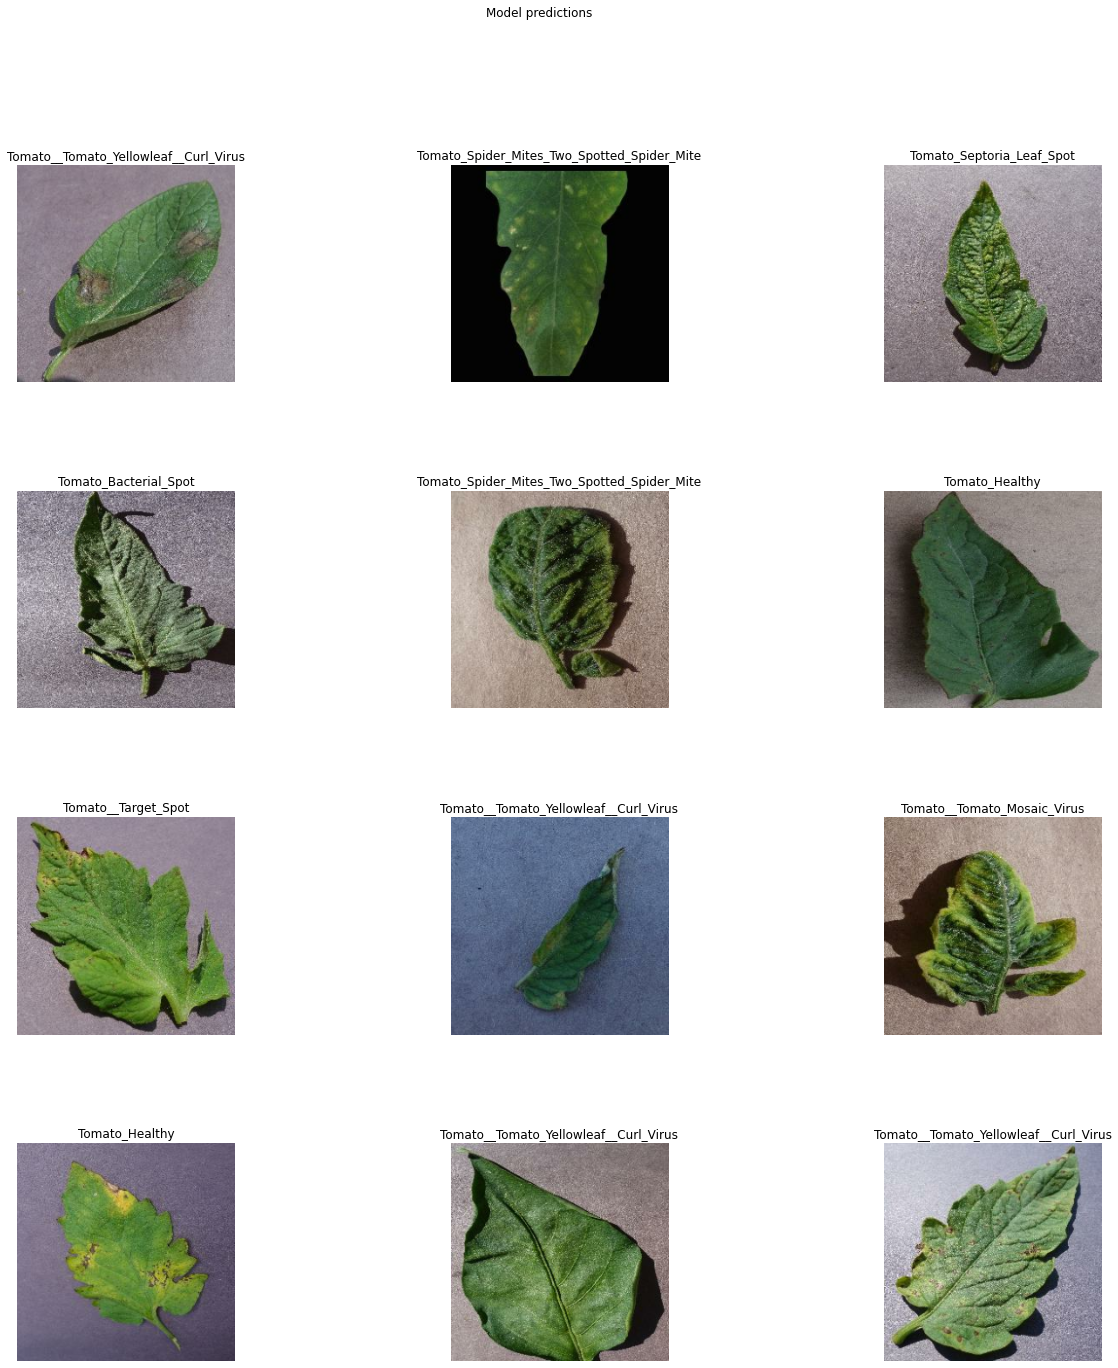

In [100]:
plt.figure(figsize=(22,22))
plt.subplots_adjust(hspace=0.5)

for n in range(12):
  plt.subplot(4,3,n+1)
  plt.imshow(test_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
  plt.suptitle("Model predictions")

In [108]:
#model.save('batch_processed_model.h5')
import time
t = time.time()

export_path = "{}".format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: 1658831880\assets


INFO:tensorflow:Assets written to: 1658831880\assets


'1658831880'

In [102]:
from keras.models import load_model

In [109]:
model11= tf.keras.models.load_model(export_path)

In [110]:
model11.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 15)                19215     
                                                                 
Total params: 2,277,199
Trainable params: 19,215
Non-trainable params: 2,257,984
_________________________________________________________________


In [171]:
import cv2
path=r'C:\Users\Asus\Documents\Machine Learning\Multi-plant-disease-ML\multi-plant-disease-dataset\\Pepper__bell___Bacterial_spot\0d8421cd-eebc-4018-b591-12352dd970a7___JR_B.Spot 3234.JPG'
img = cv2.imread(path)
resized_img = cv2.resize(img,(224,224))
resized_img = np.expand_dims(resized_img, axis=0)

In [172]:
resized_img = np.array(resized_img)/255.0
resized_img.shape

(1, 224, 224, 3)

In [173]:
prr= model.predict(resized_img)

1/1 [==============================] - 0s 46ms/step


In [174]:
prr=np.argmax(prr, axis=-1)

In [175]:
prr

array([1], dtype=int64)

In [176]:
print(class_names[prr])

['Pepper__bell___healthy']
